In [1]:
%load_ext autoreload
%autoreload 2

import json
from itertools import chain

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_curve, auc, roc_auc_score

from biobank_olink.constants import PROJECT_ROOT

sns.set()

In [2]:
results = [json.load(p.open()) for p in (PROJECT_ROOT / "results").iterdir()
           if p.name.startswith("two_extremes")]
results = pd.DataFrame(chain.from_iterable(results))
results.loc[results.panel == "IMMUNE_INFL2", "panel"] = "INFLA2+IMMUNE"

targets = results.target.unique()
panels = results.panel.unique()

agg_values = {f"mean_{v}": (v, "mean") for v in
              ["auc_score", "num_trials", "best_trial_no", "n_estimators"]}
results.groupby(["panel", "target", "no_ren"], dropna=False).agg(**agg_values,
                                                                 count=("model", 'size'))

mean_auc_score  mean_num_trials  \
panel           target no_ren                                    
ALL             DBP    False         0.795742            307.0   
                       True          0.764435            307.2   
                PP     False         0.714844            307.0   
                       True          0.703862            307.0   
                SBP    False         0.803446            307.0   
                       True          0.780793            307.0   
CARDIOMETABOLIC DBP    False         0.769167            339.0   
                       True          0.734714            314.8   
                PP     False         0.679788            307.0   
                       True          0.662010            307.0   
                SBP    False         0.772939            307.0   
                       True          0.738568            307.0   
ENDOTHELIAL     DBP    False         0.683169            307.0   
                PP     False         0.623100            307.0   
                SBP    False         0.680677            306.8   
IMMUNE          DBP    False         0.719502            307.0   
                PP     False         0.648807            307.0   
                SBP    False         0.725093            306.8   
INFL2           DBP    False         0.697223            311.4   
                PP     False         0.634683            313.2   
                SBP    False         0.699874            315.0   
INFLA2+IMMUNE   DBP    False         0.723028            307.0   
                PP     False         0.655291            307.0   
                SBP    False         0.729472            307.0   
INFLAMMATION    DBP    False         0.713695            323.0   
                PP     False         0.645060            331.0   
                SBP    False         0.725505            323.0   
NEUROLOGY       DBP    False         0.709561            307.0   
                PP     False         0.649415            306.8   
                SBP    False         0.712043            307.0   
ONCOLOGY        DBP    False         0.713060            307.0   
                PP     False         0.651819            307.0   
                SBP    False         0.718397            307.0   
RENAL           DBP    False         0.735997            307.0   
                PP     False         0.650473            306.8   
                SBP    False         0.732263            313.4   

                               mean_best_trial_no  mean_n_estimators  count  
panel           target no_ren                                                
ALL             DBP    False                230.4             4117.8      5  
                       True                 252.4             4313.8      5  
                PP     False                238.6             4015.6      5  
                       True                 233.2             3838.8      5  
                SBP    False                227.2             4532.4      5  
                       True                 213.2             4110.4      5  
CARDIOMETABOLIC DBP    False                252.0             4024.4      5  
                       True                 250.8             3645.2      5  
                PP     False                222.8             3352.2      5  
                       True                 241.2             3895.6      5  
                SBP    False                287.4             3869.2      5  
                       True                 227.4             4198.4      5  
ENDOTHELIAL     DBP    False                274.2             4215.6      5  
                PP     False                243.0             2570.2      5  
                SBP    False                258.4             3055.0      5  
IMMUNE          DBP    False                249.6             3702.4      5  
                PP     False                210.0             4454.6      5  
                SBP    False            

In [3]:
results_gb = results.groupby(["panel", "target", "no_ren"], as_index=False)
results_aucs = results_gb.agg({
    "auc_score": "mean",
    "x_shape": lambda v: v.values[0][1] if len(v.dropna()) > 0 else np.nan,
    "y_test": lambda v: np.concatenate(v.values),
    "y_proba": lambda v: np.concatenate(v.values),
})
results_aucs["auc_concat"] = results_aucs.apply(
    lambda row: roc_auc_score(row["y_test"], row["y_proba"]), axis=1)
results_aucs["exp_case"] = results_aucs.panel + results_aucs.no_ren.map(
    lambda v: " w/o REN" if v else "")
exp_col_num = results_aucs.loc[results_aucs.target == "PP"].groupby(["exp_case"]).x_shape.first()
results_aucs["x_shape"] = results_aucs.exp_case.map(exp_col_num)
results_aucs = results_aucs.pivot(index=["exp_case", "x_shape"], columns="target",
                                  values=["auc_score", "auc_concat"])
column_order = ["SBP", "DBP", "PP"]
index_order = [
    "ALL",
    "ALL w/o REN",
    "CARDIOMETABOLIC",
    "CARDIOMETABOLIC w/o REN",
    "INFLAMMATION",
    "ONCOLOGY",
    "NEUROLOGY",
]
commercial_panels_num = len(index_order)
index_order += [panel for panel in results_aucs.index.get_level_values(0).unique() if panel not in index_order]

results_aucs = results_aucs.reset_index(1).loc[index_order]
results_aucs.index += results_aucs.x_shape.astype(int).map(lambda v: f" ({v})")
results_aucs

x_shape auc_score                      \
target                                      DBP        PP       SBP   
ALL (2715)                     2715.0  0.795742  0.714844  0.803446   
ALL w/o REN (2714)             2714.0  0.764435  0.703862  0.780793   
CARDIOMETABOLIC (693)           693.0  0.769167  0.679788  0.772939   
CARDIOMETABOLIC w/o REN (692)   692.0  0.734714  0.662010  0.738568   
INFLAMMATION (675)              675.0  0.713695  0.645060  0.725505   
ONCOLOGY (685)                  685.0  0.713060  0.651819  0.718397   
NEUROLOGY (677)                 677.0  0.709561  0.649415  0.712043   
ENDOTHELIAL (202)               202.0  0.683169  0.623100  0.680677   
IMMUNE (889)                    889.0  0.719502  0.648807  0.725093   
INFL2 (504)                     504.0  0.697223  0.634683  0.699874   
INFLA2+IMMUNE (953)             953.0  0.723028  0.655291  0.729472   
RENAL (313)                     313.0  0.735997  0.650473  0.732263   

                              auc_concat                      
target                               DBP        PP       SBP  
ALL (2715)                      0.780943  0.711129  0.799167  
ALL w/o REN (2714)              0.743786  0.699106  0.772752  
CARDIOMETABOLIC (693)           0.753828  0.652271  0.761529  
CARDIOMETABOLIC w/o REN (692)   0.722669  0.632654  0.712372  
INFLAMMATION (675)              0.699941  0.627146  0.710219  
ONCOLOGY (685)                  0.700551  0.648242  0.703090  
NEUROLOGY (677)                 0.676044  0.631633  0.703519  
ENDOTHELIAL (202)               0.670929  0.583448  0.677374  
IMMUNE (889)                    0.715944  0.636900  0.719898  
INFL2 (504)                     0.690716  0.625645  0.653978  
INFLA2+IMMUNE (953)             0.719534  0.633129  0.729262  
RENAL (313)                     0.735598  0.610811  0.712327

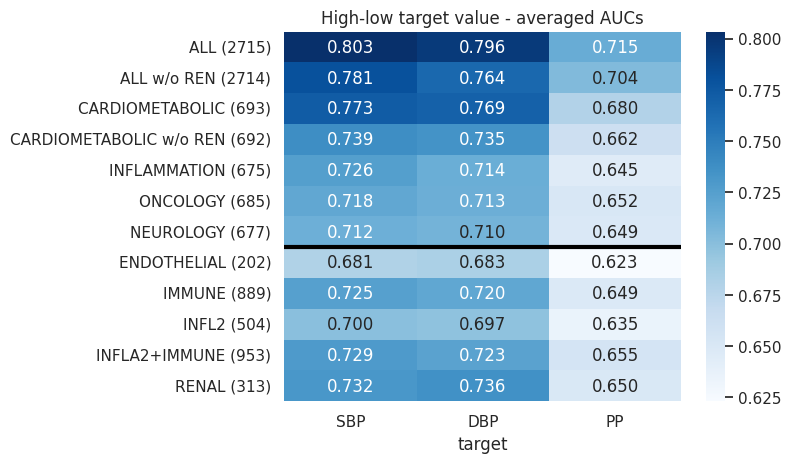

In [4]:
heatmap_kwargs = dict(annot=True, fmt=".3f", cmap="Blues")
# heatmaps
sns.heatmap(data=results_aucs["auc_score"][column_order], **heatmap_kwargs)
plt.title("High-low target value - averaged AUCs")
plt.axhline(y=commercial_panels_num, color='black', lw=3)
plt.show()
# instead of averaging AUCs, we can concatenate all fold's test sets and probas and then compute AUC
# sns.heatmap(data=results_aucs["auc_concat"][column_order], **heatmap_kwargs)
# plt.title("High-low target value - concatenated AUCs")
# plt.axhline(y=commercial_panels_num, color='black', lw=3)
# plt.show()

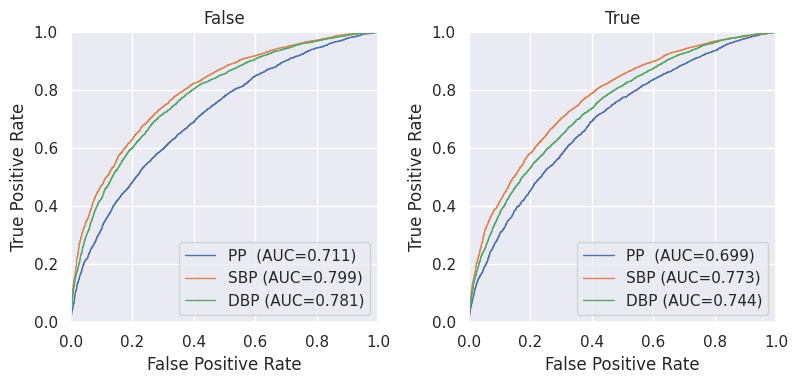

In [5]:
import matplotlib.pyplot as plt


def plot_auc_curve_by_panels(results, res_feat):
    plt.figure(figsize=(12, 4))
    for i, feat in enumerate(results[res_feat].unique(), 1):
        plt.subplot(1, 3, i)
        plt.xlim([0, 1.0])
        plt.ylim([0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(str(feat).title())

        for target in targets:
            single_case = results.loc[(results.target == target) & (results[res_feat] == feat)]
            if single_case.empty:
                continue
            y_test, y_prob = single_case["y_test"].values, single_case["y_proba"].values
            y_test, y_prob = np.concatenate(y_test), np.concatenate(y_prob)

            fpr, tpr, _ = roc_curve(y_test, y_prob)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=1, label=f"{target:<3} (AUC={auc_score:.3f})")

        plt.legend(loc='lower right')
    plt.tight_layout()


plot_auc_curve_by_panels(results.loc[results.panel == "ALL"], "no_ren")
plt.show()

In [11]:
results_xgb = results.loc[results.model == "XGBOOST"].copy()
results_xgb

,auc_score,timestamp,fold_num,best_trial_no,num_trials,study_name,target,model,panel,threshold,...,gamma,scale_pos_weight,reg_alpha,reg_lambda,grow_policy,max_bin,y_test,y_proba,shap_importance,feat_importance
0,0.635669,10/11/2023 05:52:34,2,208,307,two_extremes_xgb_corr0.9_imn_i_pp_th0.35,PP,XGBOOST,INFLA2+IMMUNE,0.35,...,3.295638,5.106177,0.464866,282.180633,lossguide,156,"[[False], [False], [True], [False], [True], [F...","[0.7687614560127258, 0.18859899044036865, 0.73...","{'ABL1': 4.627089023590088, 'ACE': 9.605401039...","{'ABL1': 0.0009210626012645662, 'ACE': 0.00096..."
1,0.684665,10/11/2023 06:50:23,3,305,307,two_extremes_xgb_corr0.9_imn_i_pp_th0.35,PP,XGBOOST,INFLA2+IMMUNE,0.35,...,1.977415,1.975767,9.044279,199.251620,lossguide,224,"[[False], [True], [False], [True], [False], [F...","[0.5839035511016846, 0.7124412655830383, 0.230...","{'ABL1': 1.343546748161316, 'ACE': 16.70349693...","{'ABL1': 0.00101253273896873, 'ACE': 0.0010947..."
2,0.657562,10/11/2023 06:51:41,1,253,307,two_extremes_xgb_corr0.9_imn_i_pp_th0.35,PP,XGBOOST,INFLA2+IMMUNE,0.35,...,1.925024,7.378281,20.754147,479.149042,depthwise,745,"[[True], [False], [False], [False], [True], [T...","[0.8427353501319885, 0.59173583984375, 0.77846...","{'ABL1': 2.963510274887085, 'ACE': 3.074740409...","{'ABL1': 0.0011126183671876788, 'ACE': 0.00082..."
3,0.639712,10/11/2023 06:53:15,0,258,307,two_extremes_xgb_corr0.9_imn_i_pp_th0.35,PP,XGBOOST,INFLA2+IMMUNE,0.35,...,4.997664,10.062612,2.455034,73.417819,lossguide,467,"[[False], [True], [False], [False], [False], [...","[0.8573776483535767, 0.9524593949317932, 0.706...","{'ABL1': 7.9510979652404785, 'ACE': 4.58000373...","{'ABL1': 0.0009941740427166224, 'ACE': 0.00096..."
4,0.658849,10/11/2023 06:54:00,4,285,307,two_extremes_xgb_corr0.9_imn_i_pp_th0.35,PP,XGBOOST,INFLA2+IMMUNE,0.35,...,8.202689,12.246706,1.513981,54.063003,lossguide,85,"[[True], [True], [False], [False], [True], [Tr...","[0.9502362012863159, 0.9164414405822754, 0.757...","{'ABL1': 4.625232219696045, 'ACE': 3.127179622...","{'ABL1': 0.0009913030080497265, 'ACE': 0.00106..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.665387,10/11/2023 12:08:14,3,198,307,two_extremes_xgb_corr0.9_neuro_pp_th0.35,PP,XGBOOST,NEUROLOGY,0.35,...,8.302925,8.490578,7.739831,353.848690,lossguide,654,"[[False], [True], [False], [True], [False], [F...","[0.8650345206260681, 0.8872072696685791, 0.615...","{'ABHD14B': 11.265694618225098, 'ACVRL1': 37.5...","{'ABHD14B': 0.0015011222567409277, 'ACVRL1': 0..."
176,0.657673,10/11/2023 12:08:16,0,277,307,two_extremes_xgb_corr0.9_neuro_pp_th0.35,PP,XGBOOST,NEUROLOGY,0.35,...,4.136205,4.126631,0.851581,342.488452,depthwise,663,"[[False], [True], [False], [False], [False], [...","[0.7035236954689026, 0.8332257866859436, 0.594...","{'ABHD14B': 22.99455451965332, 'ACVRL1': 14.23...","{'ABHD14B': 0.0014127277536317706, 'ACVRL1': 0..."
177,0.636999,10/11/2023 12:08:17,2,191,307,two_extremes_xgb_corr0.9_neuro_pp_th0.35,PP,XGBOOST,NEUROLOGY,0.35,...,1.186587,2.911461,2.660011,923.961639,lossguide,624,"[[False], [False], [True], [False], [True], [F...","[0.6642610430717468, 0.38305723667144775, 0.66...","{'ABHD14B': 19.846050262451172, 'ACVRL1': 34.5...","{'ABHD14B': 0.0013375482521951199, 'ACVRL1': 0..."
178,0.644628,10/11/2023 12:08:24,1,231,306,two_extremes_xgb_corr0.9_neuro_pp_th0.35,PP,XGBOOST,NEUROLOGY,0.35,...,2.414108,17.623920,0.901572,641.843678,depthwise,165,"[[True], [False], [False], [False], [True], [T...","[0.9437302947044373, 0.8591085076332092, 0.913...","{'ABHD14B': 6.613325119018555, 'ACVRL1': 42.08...","{'ABHD14B': 0.0012868907069787383, 'ACVRL1': 0..."


## Feature importances

In [16]:
feat_imps = results_xgb.loc[
    (results_xgb.target == "SBP") & (results_xgb.panel == "ALL") & (results_xgb.no_ren == False)

].shap_importance
feat_imps = pd.DataFrame(list(feat_imps.values)).T.sort_values(0, ascending=False)
feat_imps.rank(ascending=False).astype(int)

,0,1,2,3,4
REN,1,1,1,1,1
PTPRB,2,2,2,2,2
ACTA2,3,3,3,3,3
SPINK6,4,8,7,10,6
AMIGO2,5,4,5,4,8
...,...,...,...,...,...
TP53I3,2655,2622,2628,2699,2354
UBE2L6,2655,2370,2628,2680,2681
UBE2B,2655,1566,2137,1799,2547
PPT1,2655,1594,2462,1607,1939


In [17]:
from biobank_olink.dataset import get_olink_panel_mapping, compute_correlations_in_df

ol_df_corr = compute_correlations_in_df(None, shape=(53029, 2923))
corr_th = 0.8
mask = np.triu(np.ones(ol_df_corr.shape), k=1).astype(bool)
high_corr = ol_df_corr.where(mask)
correlated_cols = {column: dict(zip(high_corr.columns[high_corr[column] > corr_th].tolist(),
                                    high_corr[column][high_corr[column] > corr_th].tolist()))
                   for column in high_corr.columns}

assays_mapping = get_olink_panel_mapping()


def olink_to_panels(olink):
    return [
        panel
        for panel, olinks in assays_mapping.items()
        if olink in olinks
    ]


def get_feat_imps(res, panel):
    feat_imps = (
        res.loc[(res.panel == panel)]
        .groupby("target").shap_importance
        .apply(lambda x: pd.DataFrame(x.values.tolist()).mean().sort_values(ascending=False))
        .unstack("target")
    )
    present_targets = [col for col in targets if col in feat_imps.columns]
    feat_imps = feat_imps[present_targets]
    feat_ranks = feat_imps.rank(ascending=False)
    feat_ranks.columns = [f"{col}_rank" for col in feat_ranks.columns]
    feat_imps = pd.concat([feat_imps, feat_ranks], axis=1)
    feat_imps = feat_imps[[f"{col}{suffix}" for col in present_targets for suffix in ["", "_rank"]]]
    return feat_imps


feat_imps = get_feat_imps(results_xgb, "ALL")
feat_imps["panel"] = feat_imps.index.map(olink_to_panels)
feat_imps[f"correlates_with (corr>{corr_th})"] = feat_imps.index.map(correlated_cols)
feat_imps.sort_values("SBP", ascending=False)

[Memory]0.0s, 0.0min    : Loading compute_correlations_in_df...


,PP,PP_rank,SBP,SBP_rank,DBP,DBP_rank,panel,correlates_with (corr>0.8)
REN,464.504211,1.0,1107.597705,1.0,1113.152173,1.0,"[cardiometabolic, bp, renal]",{}
PTPRB,228.758282,2.0,421.251166,2.0,300.025987,3.0,[cardiometabolic],{}
ACTA2,205.379807,3.0,387.458701,3.0,324.404753,2.0,"[cardiometabolic, bp, renal]",{}
AMIGO2,164.431737,6.0,264.873442,4.0,83.494918,49.0,[oncology],{}
CHGB,192.092426,4.0,237.045155,5.0,116.055899,27.0,[neurology],{}
...,...,...,...,...,...,...,...,...
ANKMY2,1.182395,2665.0,0.411723,2711.0,1.683155,2609.0,[inflammation],{'AKT2': 0.8446529525356101}
IGBP1,1.699143,2583.0,0.253791,2712.0,0.783621,2712.0,"[neurology, immune, infl2, imn_inf2]","{'ACYP1': 0.8403525759841207, 'ATG4A': 0.80467..."
CMIP,1.271687,2652.0,0.243651,2713.0,3.555313,2126.0,[oncology],"{'ACOT13': 0.827184960452486, 'AK2': 0.8097057..."
PLEKHO1,0.869953,2698.0,0.239985,2714.0,4.049688,1984.0,[neurology],"{'ABL1': 0.8373674755931851, 'AKT2': 0.8224844..."


## export all feature importances

In [173]:
from biobank_olink.constants import PROJECT_DATA

feat_importances_dir = PROJECT_DATA / "feat_importances"
feat_importances_dir.mkdir(exist_ok=True)

for study_name in results.study_name.unique():
    series = []
    study_res = results.loc[results.study_name == study_name]

    feat_imps = study_res.feat_importance
    series.append(feat_imps.apply(pd.Series).mean())
    series.append(feat_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    shap_imps = study_res.shap_importance
    series.append(shap_imps.apply(pd.Series).mean())
    series.append(shap_imps.apply(pd.Series).rank(ascending=False, axis=1).mean())

    importance = pd.concat(series, axis=1)
    importance.columns = ["feat_importance", "feat_importance_rank",
                          "shap_importance", "shap_importance_rank"]
    importance["panel"] = importance.index.map(olink_to_panels)
    importance[f"correlates_with (corr>{corr_th})"] = importance.index.map(correlated_cols)
    importance.to_csv(feat_importances_dir / f"{study_name}.csv")

## LogisticRegressions - interactions

In [ ]:
res_inter = results.loc[results.interactions > 0]
res_inter.groupby(["model", "panel", "target", "interactions"]).agg(**agg_values,
                                                                    count=("model", 'size'))

In [ ]:
get_feat_imps(res_inter, "all").sort_values("SBP", ascending=False)

## N best features

In [ ]:
res_n_best = results.loc[results.n_best_feats.notna()]
res_n_best.groupby(["model", "panel", "target", "n_best_feats"]).agg(**agg_values,
                                                                     count=("model", 'size'))

In [ ]:
feat_imps_n_best200 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 200],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best200

In [ ]:
feat_imps_n_best500 = get_feat_imps(res_n_best.loc[res_n_best.n_best_feats == 500],
                                    "all").sort_values("SBP", ascending=False)
feat_imps_n_best500

In [ ]:
n = 10
len(feat_imps_n_best500.index[:n].intersection(feat_imps_n_best200.index[:n])) / n